In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parâmetros da simulação
N = 100  # Número de partículas
e = 0.9  # Coeficiente de restituição
k_B = 1.38e-23  # Constante de Boltzmann (J/K)
T_g = 300  # Temperatura inicial granular (K)
v_flux = 10  # Velocidade inicial do fluxo (m/s)
timesteps = 1000  # Número de passos de tempo
dt = 1e-3  # Intervalo de tempo (s)
L = 1  # Comprimento do domínio (m)
m_particle = 0.01  # Massa das partículas (kg)
diameter_particle = 0.02  # Diâmetro das partículas (m)
m_cunha = 1  # Massa da cunha (kg)

# Inicialização das partículas
def inicializar_particulas(N, T_g, m_particle, v_flux):
    pos = np.random.rand(N, 2) * L  # Posições iniciais
    vel = np.random.normal(0, np.sqrt(k_B * T_g / m_particle), (N, 2)) + v_flux  # Velocidades iniciais
    return pos, vel

# Definição da cunha (avião)
cunha_pos = np.array([L / 2, L / 2])
cunha_angle = np.pi / 4  # Ângulo da cunha (45 graus)
cunha_vel = np.array([-v_flux * np.cos(cunha_angle), -v_flux * np.sin(cunha_angle)])  # Velocidade da cunha

def simular(N, pos, vel, cunha_pos, cunha_angle, cunha_vel, timesteps, dt, diameter_particle, e):
    for t in range(timesteps):
        # Atualizar posição da cunha
        cunha_pos += cunha_vel * dt

        # Atualizar posições das partículas
        pos += vel * dt

        # Verificar colisões com a cunha
        normal_cunha = np.array([np.cos(cunha_angle), np.sin(cunha_angle)])
        rel_pos_cunha = pos - cunha_pos
        dist_cunha = np.dot(rel_pos_cunha, normal_cunha)
        colisao_cunha = dist_cunha < diameter_particle / 2
        vel[colisao_cunha] = vel[colisao_cunha] - 2 * np.dot(vel[colisao_cunha], normal_cunha)[:, np.newaxis] * normal_cunha

        # Verificar colisões entre partículas
        for i in range(N):
            for j in range(i + 1, N):
                if np.linalg.norm(pos[i] - pos[j]) < diameter_particle:
                    v_i = vel[i]
                    v_j = vel[j]
                    vel[i] = (v_i + v_j) / 2 + e * (v_i - v_j) / 2
                    vel[j] = (v_i + v_j) / 2 - e * (v_i - v_j) / 2

    return pos, vel, cunha_pos

# Intervalos de variação
d_values = np.linspace(0.6e-5, 0.6e-2, 5)
m_values = np.linspace(0.0001, 0.01, 5)

# Criação do GIF
fig, ax = plt.subplots(figsize=(8, 6))
ims = []

for d in d_values:
    for m in m_values:
        # Inicializar partículas
        pos, vel = inicializar_particulas(N, T_g, m_particle, v_flux)
        cunha_pos = np.array([L / 2, L / 2])

        # Executar a simulação
        pos, vel, cunha_pos = simular(N, pos, vel, cunha_pos, cunha_angle, cunha_vel, timesteps, dt, diameter_particle, e)

        # Calcular propriedades macroscópicas
        T_g_calc = np.mean(np.linalg.norm(vel, axis=1)**2) * m_particle / k_B
        rho = N / L**2
        P = rho * T_g_calc * (1 + e**2)

        # Geração de gráficos
        v_bins = np.linspace(np.min(np.linalg.norm(vel, axis=1)), np.max(np.linalg.norm(vel, axis=1)), 100)
        pdf_v = (m_particle / (2 * np.pi * k_B * T_g_calc))**1.5 * np.exp(-m_particle * v_bins**2 / (2 * k_B * T_g_calc))

        hist = ax.hist(np.linalg.norm(vel, axis=1), bins=100, density=True, alpha=0.6, color='g')
        line, = ax.plot(v_bins, pdf_v, 'k-', lw=2)
        ax.set_title(f'Distribuição de Velocidades (d={d:.1e}, m={m:.1e})')
        ax.set_xlabel('Velocidade (m/s)')
        ax.set_ylabel('Densidade de Probabilidade')
        ims.append([hist, line])

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True)
ani.save('simulacao_granular.gif', writer='pillow')  # Salvar com Pillow ao invés de ImageMagick

plt.show()


<IPython.core.display.Javascript object>

IndexError: list index out of range

In [ ]:
!pip install matplotlib numpy imageio

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Função para atualizar as posições e velocidades das partículas
def update_particles(positions, velocities, time_step):
    velocities[:, 1] -= g * time_step  # Atualização da velocidade vertical devido à gravidade
    positions += velocities * time_step  # Atualização das posições
    return positions, velocities

# Função para calcular os campos de velocidade, densidade e temperatura
def calculate_fields(positions, velocities):
    velocity_field = np.mean(velocities, axis=0)
    density_field = len(positions) / (np.max(positions[:, 0]) - np.min(positions[:, 0])) * (np.max(positions[:, 1]) - np.min(positions[:, 1]))
    temperature_field = np.var(velocities)
    return velocity_field, density_field, temperature_field

# Parâmetros da simulação
num_particles = 1000
particle_diameter = 1.2  # mm
g = 9.81  # m/s^2
time_step = 0.001  # s
num_steps = 1000
frames_dir = 'frames'
os.makedirs(frames_dir, exist_ok=True)

# Inicialização das partículas
positions = np.random.rand(num_particles, 2) * 10
velocities = np.zeros((num_particles, 2))

# Lista para armazenar os frames da simulação
filenames = []

# Simulação da dinâmica molecular e criação dos frames
for step in range(num_steps):
    positions, velocities = update_particles(positions, velocities, time_step)
    if step % 10 == 0:
        plt.figure(figsize=(10, 6))
        plt.quiver(positions[:, 0], positions[:, 1], velocities[:, 0], velocities[:, 1])
        plt.title('Campo de Velocidade das Partículas - Passo {}'.format(step))
        plt.xlabel('X (mm)')
        plt.ylabel('Y (mm)')
        frame_filename = os.path.join(frames_dir, 'frame_{:04d}.png'.format(step))
        plt.savefig(frame_filename)
        filenames.append(frame_filename)
        plt.close()

# Criar GIF da simulação
with imageio.get_writer('particle_simulation.gif', mode='I', duration=0.1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Cálculo dos campos de velocidade, densidade e temperatura
velocity_field, density_field, temperature_field = calculate_fields(positions, velocities)

# Dados experimentais para comparação
experimental_velocity_field = np.array([1.65, 0])  # Exemplo dos dados experimentais fornecidos
experimental_density_field = 0.018
experimental_temperature_field = 0.09

# Criação de gráficos para comparação
plt.figure(figsize=(10, 6))
plt.bar(['Simulação', 'Experimento'], [velocity_field[0], experimental_velocity_field[0]])
plt.title('Comparação do Campo de Velocidade')
plt.ylabel('Velocidade (m/s)')
plt.savefig('velocity_comparison.png')
plt.close()

plt.figure(figsize=(10, 6))
plt.bar(['Simulação', 'Experimento'], [density_field, experimental_density_field])
plt.title('Comparação do Campo de Densidade')
plt.ylabel('Densidade (partículas/mm²)')
plt.savefig('density_comparison.png')
plt.close()

plt.figure(figsize=(10, 6))
plt.bar(['Simulação', 'Experimento'], [temperature_field, experimental_temperature_field])
plt.title('Comparação do Campo de Temperatura')
plt.ylabel('Temperatura (K)')
plt.savefig('temperature_comparison.png')
plt.close()

# Criação de GIF da comparação
comparison_filenames = ['velocity_comparison.png', 'density_comparison.png', 'temperature_comparison.png']
with imageio.get_writer('comparison.gif', mode='I', duration=1) as writer:
    for filename in comparison_filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


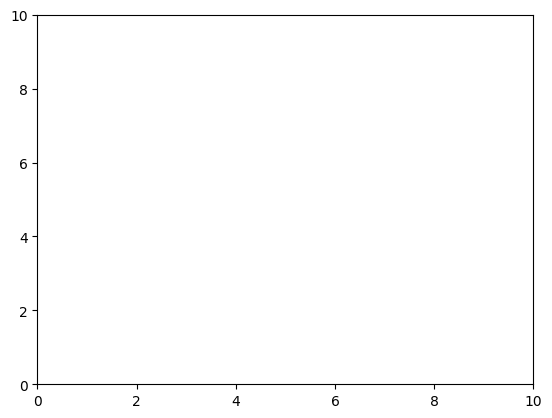

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parâmetros da simulação
num_particles = 100
box_size = 10
particle_radius = 0.1
dt = 0.01
num_steps = 1000

# Inicialização das partículas
positions = np.random.rand(num_particles, 2) * box_size
velocities = np.random.randn(num_particles, 2)

def compute_forces(positions):
    forces = np.zeros_like(positions)
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            displacement = positions[j] - positions[i]
            distance = np.linalg.norm(displacement)
            if distance < 2 * particle_radius:
                force_magnitude = (2 * particle_radius - distance)
                force_direction = displacement / distance
                force = force_magnitude * force_direction
                forces[i] -= force
                forces[j] += force
    return forces

def update_positions(positions, velocities):
    positions += velocities * dt
    positions = np.mod(positions, box_size)  # condições de contorno periódicas
    return positions

def update_velocities(velocities, forces):
    velocities += forces * dt
    return velocities

# Simulação
positions_over_time = [positions.copy()]
for _ in range(num_steps):
    forces = compute_forces(positions)
    velocities = update_velocities(velocities, forces)
    positions = update_positions(positions, velocities)
    positions_over_time.append(positions.copy())

# Visualização
fig, ax = plt.subplots()
particles, = ax.plot([], [], 'bo', ms=6)

def init():
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    return particles,

def animate(i):
    pos = positions_over_time[i]
    particles.set_data(pos[:, 0], pos[:, 1])
    return particles,

ani = FuncAnimation(fig, animate, frames=num_steps, init_func=init, blit=True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Parâmetros da simulação
num_particles = 1000
particle_diameter = 1.2  # mm
g = 9.81  # m/s^2
time_step = 0.001  # s
num_steps = 1000
frames_dir = 'frames'
os.makedirs(frames_dir, exist_ok=True)

# Inicialização das partículas
positions = np.random.rand(num_particles, 2) * 10 + np.array([5, 10])  # Partículas iniciam acima da cunha
velocities = np.zeros((num_particles, 2))

# Função para atualizar as posições e velocidades das partículas
def update_particles(positions, velocities, time_step):
    velocities[:, 1] -= g * time_step  # Atualização da velocidade vertical devido à gravidade
    positions += velocities * time_step  # Atualização das posições
    return positions, velocities

# Função para verificar colisões com a cunha
def check_collisions(positions, velocities):
    for i in range(num_particles):
        if positions[i, 1] <= positions[i, 0]:  # Condição da cunha triangular
            velocities[i, 1] = -velocities[i, 1]  # Inverte a velocidade vertical
    return positions, velocities

# Simulação da dinâmica molecular e criação dos frames
filenames = []
for step in range(num_steps):
    positions, velocities = update_particles(positions, velocities, time_step)
    positions, velocities = check_collisions(positions, velocities)
    if step % 10 == 0:
        plt.figure(figsize=(10, 6))
        plt.scatter(positions[:, 0], positions[:, 1], c=velocities[:, 1], cmap='hot', s=particle_diameter)
        plt.title('Simulação de Partículas - Passo {}'.format(step))
        plt.xlabel('X (mm)')
        plt.ylabel('Y (mm)')
        plt.colorbar(label='Velocidade Vertical')
        frame_filename = os.path.join(frames_dir, 'frame_{:04d}.png'.format(step))
        plt.savefig(frame_filename)
        filenames.append(frame_filename)
        plt.close()

# Criar GIF da simulação
with imageio.get_writer('particle_simulation.gif', mode='I', duration=0.1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Cálculo do campo de temperatura
def calculate_temperature_field(velocities):
    temperature_field = np.var(velocities, axis=0)
    return temperature_field

temperature_field = calculate_temperature_field(velocities)

# Visualização do campo de temperatura
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], c=temperature_field, cmap='hot', s=particle_diameter)
plt.title('Campo de Temperatura das Partículas')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.colorbar(label='Temperatura')
plt.savefig('temperature_field.png')
plt.close()

# Criação de GIF da temperatura
temperature_filenames = [os.path.join(frames_dir, 'frame_{:04d}.png'.format(step)) for step in range(0, num_steps, 10)]
with imageio.get_writer('temperature_field.gif', mode='I', duration=0.1) as writer:
    for filename in temperature_filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os

# Parâmetros da simulação
num_particles = 1000
particle_diameter = 1.2  # mm
g = 9.81  # m/s^2
time_step = 0.001  # s
num_steps = 1000
frames_dir = 'frames'
os.makedirs(frames_dir, exist_ok=True)

# Inicialização das partículas
positions = np.random.rand(num_particles, 2) * 10 + np.array([5, 10])  # Partículas iniciam acima da cunha
velocities = np.zeros((num_particles, 2))

# Função para atualizar as posições e velocidades das partículas
def update_particles(positions, velocities, time_step):
    velocities[:, 1] -= g * time_step  # Atualização da velocidade vertical devido à gravidade
    positions += velocities * time_step  # Atualização das posições
    return positions, velocities

# Função para verificar colisões com a cunha
def check_collisions(positions, velocities):
    for i in range(num_particles):
        if positions[i, 1] <= positions[i, 0]:  # Condição da cunha triangular
            velocities[i, 1] = -velocities[i, 1]  # Inverte a velocidade vertical
    return positions, velocities

# Simulação da dinâmica molecular e criação dos frames
filenames = []
temperature_filenames = []
for step in range(num_steps):
    positions, velocities = update_particles(positions, velocities, time_step)
    positions, velocities = check_collisions(positions, velocities)
    if step % 10 == 0:
        # Criação do frame para o movimento das partículas
        plt.figure(figsize=(10, 6))
        plt.scatter(positions[:, 0], positions[:, 1], c=velocities[:, 1], cmap='hot', s=particle_diameter)
        plt.title('Simulação de Partículas - Passo {}'.format(step))
        plt.xlabel('X (mm)')
        plt.ylabel('Y (mm)')
        plt.colorbar(label='Velocidade Vertical')
        frame_filename = os.path.join(frames_dir, 'frame_{:04d}.png'.format(step))
        plt.savefig(frame_filename)
        filenames.append(frame_filename)
        plt.close()

        # Criação do frame para o campo de temperatura
        temperature_field = np.var(velocities, axis=1)
        plt.figure(figsize=(10, 6))
        plt.scatter(positions[:, 0], positions[:, 1], c=temperature_field, cmap='hot', s=particle_diameter)
        plt.title('Campo de Temperatura das Partículas - Passo {}'.format(step))
        plt.xlabel('X (mm)')
        plt.ylabel('Y (mm)')
        plt.colorbar(label='Temperatura')
        temp_frame_filename = os.path.join(frames_dir, 'temp_frame_{:04d}.png'.format(step))
        plt.savefig(temp_frame_filename)
        temperature_filenames.append(temp_frame_filename)
        plt.close()

# Criar GIF do movimento das partículas
with imageio.get_writer('particle_simulation.gif', mode='I', duration=0.1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Criar GIF do campo de temperatura
with imageio.get_writer('temperature_field.gif', mode='I', duration=0.1) as writer:
    for filename in temperature_filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


sved figure  0
sved figure  10
sved figure  20
sved figure  30
sved figure  40
sved figure  50
sved figure  60
sved figure  70
sved figure  80
sved figure  90
sved figure  100
sved figure  110
sved figure  120
sved figure  130
sved figure  140
sved figure  150
sved figure  160
sved figure  170
sved figure  180
sved figure  190
sved figure  200
sved figure  210
sved figure  220
sved figure  230
sved figure  240
sved figure  250
sved figure  260
sved figure  270
sved figure  280
sved figure  290
sved figure  300
sved figure  310
sved figure  320
sved figure  330
sved figure  340
sved figure  350
sved figure  360
sved figure  370
sved figure  380
sved figure  390
sved figure  400
sved figure  410
sved figure  420
sved figure  430
sved figure  440
sved figure  450
sved figure  460
sved figure  470
sved figure  480
sved figure  490
sved figure  500
sved figure  510
sved figure  520
sved figure  530
sved figure  540
sved figure  550
sved figure  560
sved figure  570
sved figure  580
sved fig

KeyboardInterrupt: 

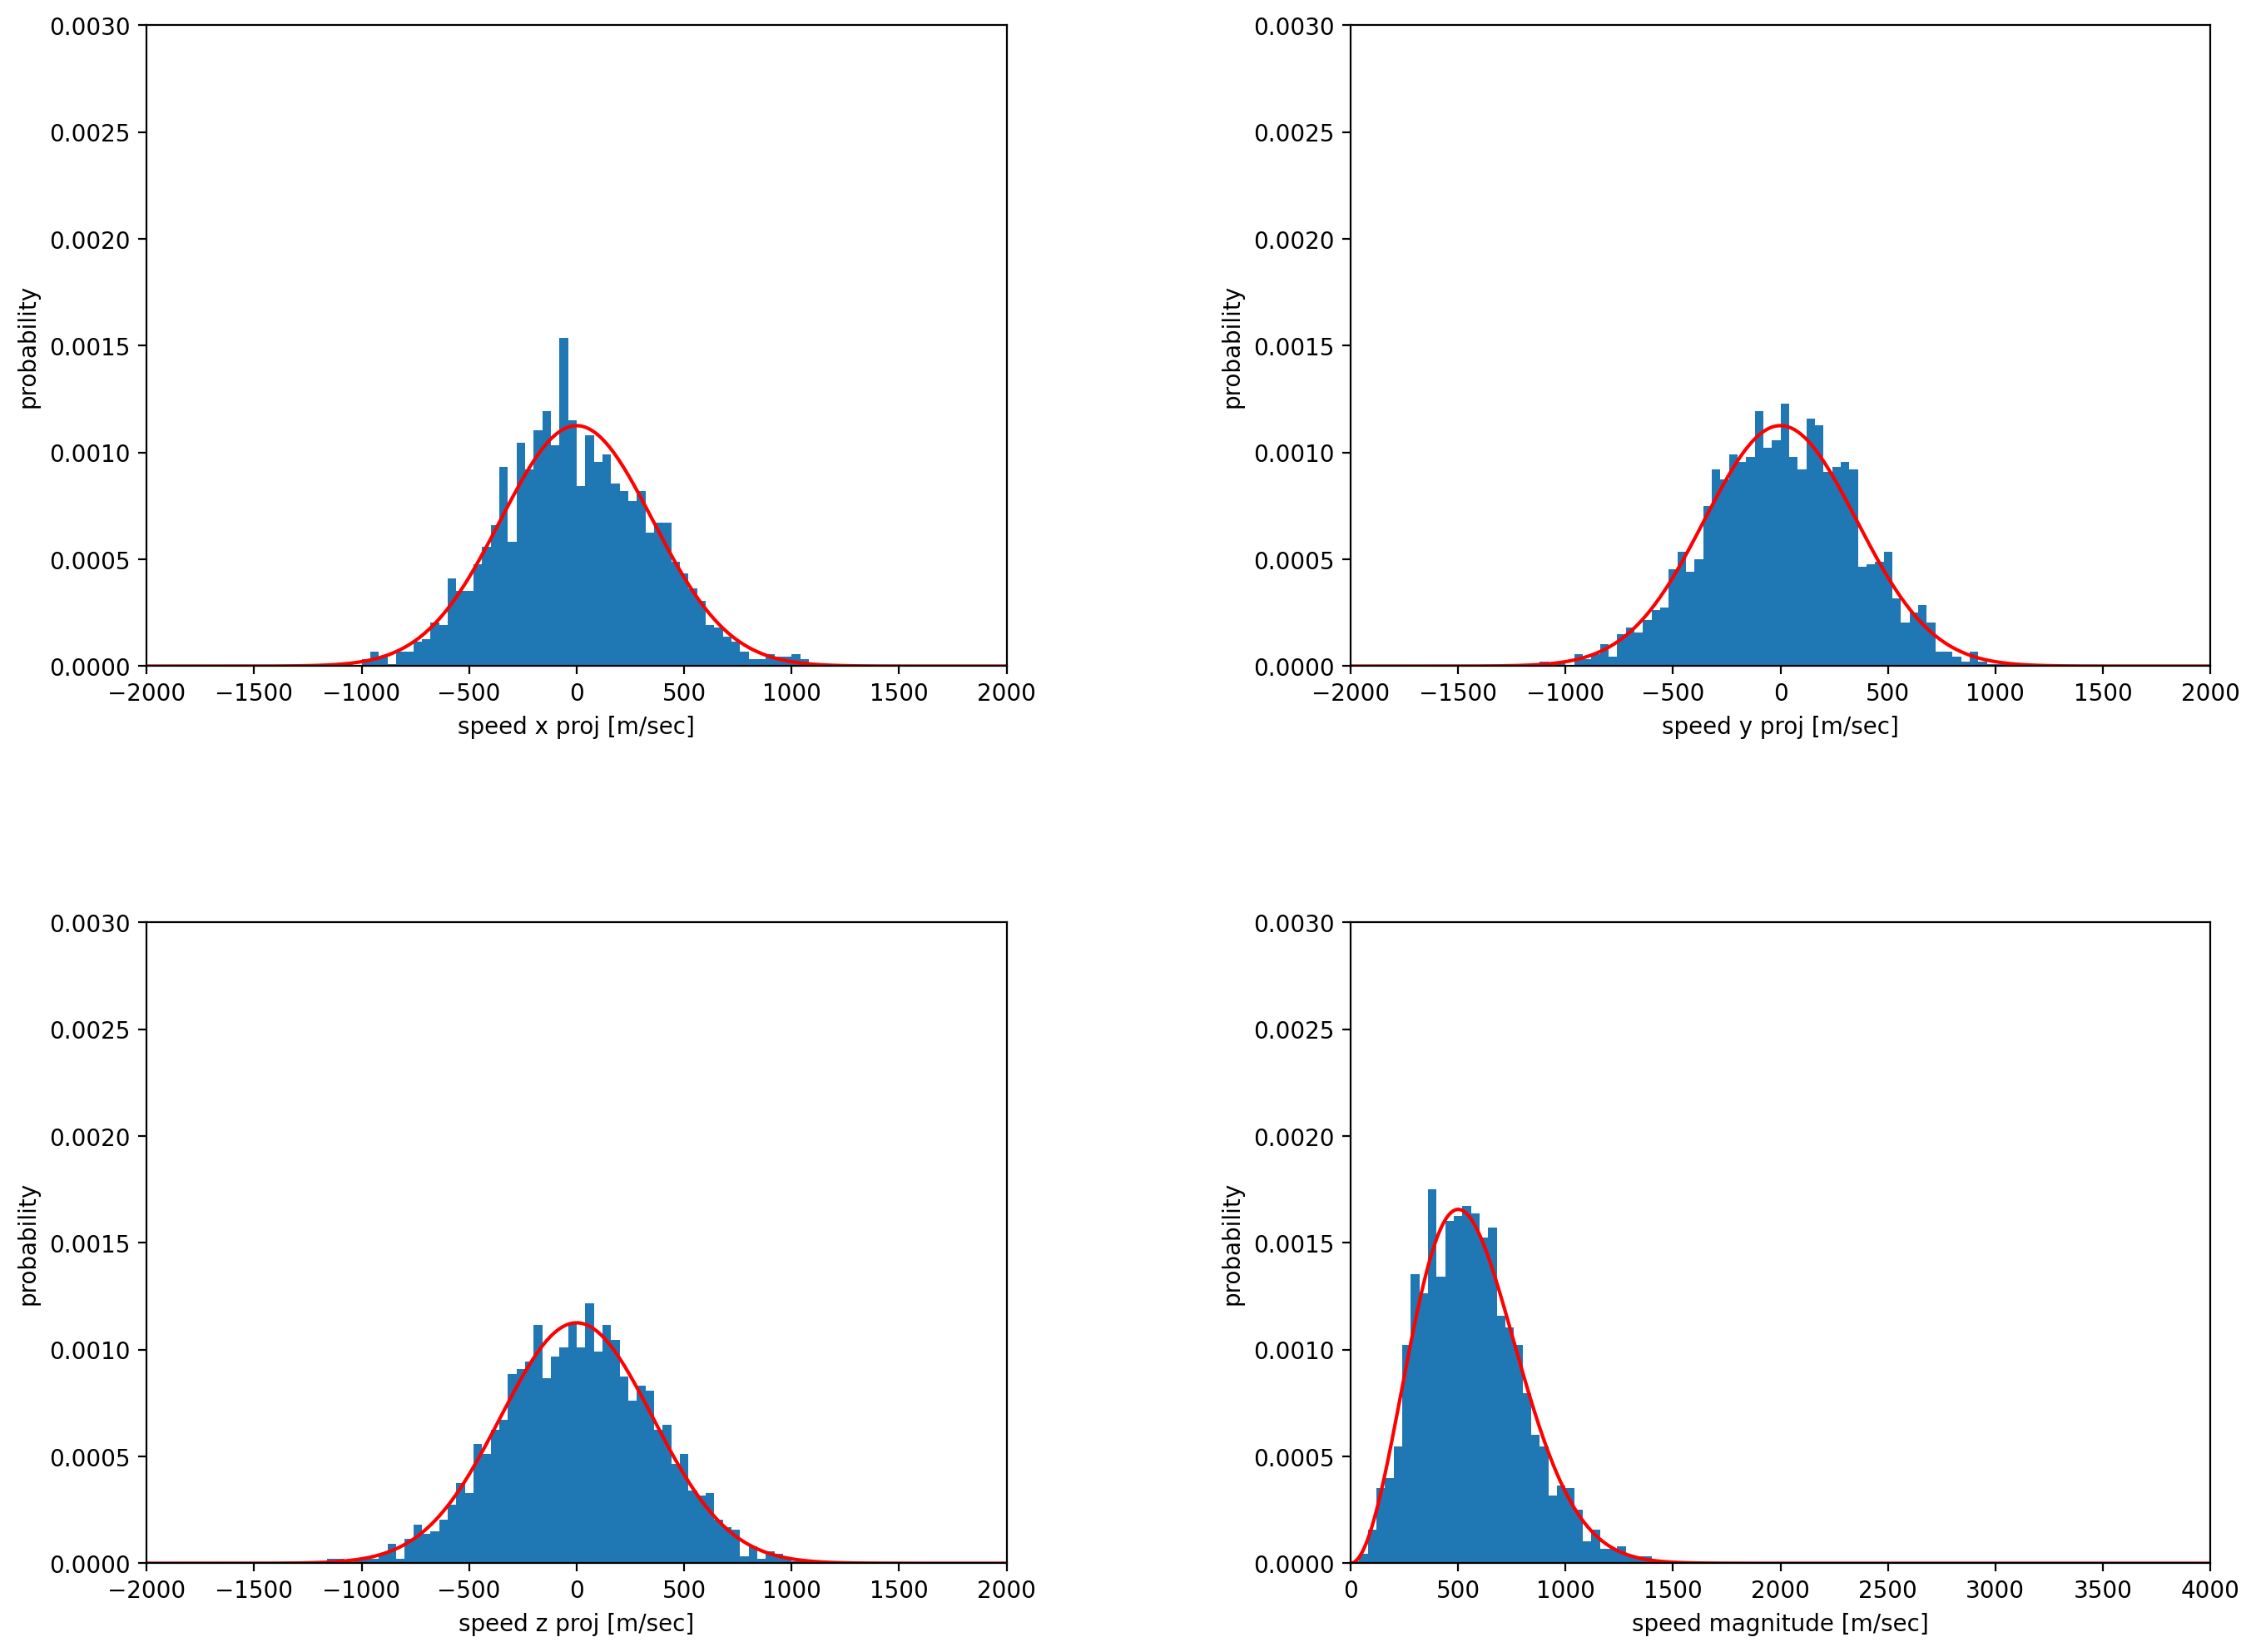

In [ ]:
# It plots speed distribution frame by frame
# I know that it seems like bad code. I tried to use matplotlib.animation, but I failed.
import numpy as np
import matplotlib.pyplot as plt
from particles_system import ParticlesSystem

BINS = 100
SPEED_LIM = 4000
Y_LIM = 0.003
DENSITY = True
dt = 1e-13

system = ParticlesSystem(radius=2e-10, mass=3.3e-26, volume=1e-23, pressure=10e5, temperature=300, init_type='uniform')

fig = plt.figure('Maxwell speed distribution', figsize=(16, 12), dpi=200, facecolor='w')
ax = [[0, 0], [0, 0]]
for i in range(2):
    for j in range(2):
        ax[i][j] = fig.add_subplot(2, 2, i * 2 + j + 1)
fig.subplots_adjust(wspace=0.4, hspace=0.4)

# Theoretical Maxwell distribution
v_mag = np.linspace(0, SPEED_LIM, 1000)
v_proj = np.linspace(-SPEED_LIM / 2, SPEED_LIM / 2, 1000)
prob_proj = ((system.mass / (2 * np.pi * 1.38062e-23 * system.temperature)) ** (1 / 2)) * np.exp(
    -system.mass * np.square(v_proj) / (2 * 1.38062e-23 * system.temperature))
prob_mag = 4 * np.pi * np.square(v_mag) * (
        (system.mass / (2 * np.pi * 1.38062e-23 * system.temperature)) ** (3 / 2)) * np.exp(
    -system.mass * np.square(v_mag) / (2 * 1.38062e-23 * system.temperature))


def plot_speed_dist(s: ParticlesSystem, savepath):
    for i in range(2):
        for j in range(2):
            ax[i][j].clear()
    ax[0][0].set_xlabel('speed x proj [m/sec]')
    ax[0][0].set_xlim(-SPEED_LIM / 2, SPEED_LIM / 2)
    ax[0][0].set_ylabel('probability')
    ax[0][0].set_ylim(0, Y_LIM)
    ax[0][0].set_label('distribution v_x')
    ax[0][0].plot(v_proj, prob_proj, color='red')
    ax[0][0].hist(s.get_velocities_x(), bins=BINS, range=(-SPEED_LIM / 2, SPEED_LIM / 2), density=DENSITY)

    ax[0][1].set_xlabel('speed y proj [m/sec]')
    ax[0][1].set_xlim(-SPEED_LIM / 2, SPEED_LIM / 2)
    ax[0][1].set_ylabel('probability')
    ax[0][1].set_ylim(0, Y_LIM)
    ax[0][1].set_label('distribution v_y')
    ax[0][1].plot(v_proj, prob_proj, color='red')
    ax[0][1].hist(s.get_velocities_y(), bins=BINS, range=(-SPEED_LIM / 2, SPEED_LIM / 2), density=DENSITY)

    ax[1][0].set_xlabel('speed z proj [m/sec]')
    ax[1][0].set_xlim(-SPEED_LIM / 2, SPEED_LIM / 2)
    ax[1][0].set_ylabel('probability')
    ax[1][0].set_ylim(0, Y_LIM)
    ax[1][0].set_label('distribution v_z')
    ax[1][0].plot(v_proj, prob_proj, color='red')
    ax[1][0].hist(s.get_velocities_z(), bins=BINS, range=(-SPEED_LIM / 2, SPEED_LIM / 2), density=DENSITY)

    ax[1][1].set_xlabel('speed magnitude [m/sec]')
    ax[1][1].set_xlim(0, SPEED_LIM)
    ax[1][1].set_ylabel('probability')
    ax[1][1].set_ylim(0, Y_LIM)
    ax[1][1].set_label('distribution v_mag')
    ax[1][1].plot(v_mag, prob_mag, color='red')
    ax[1][1].hist(s.get_velocities_magnitude(), bins=BINS, range=(0, SPEED_LIM), density=DENSITY)
    fig.savefig(savepath)
    #plt.show()


counter = 0

while 1:
    if counter % 10 == 0:
        plot_speed_dist(system, f'{counter}.png')
        print('sved figure ', counter)
    system.iteration(dt=dt)
    counter += 1

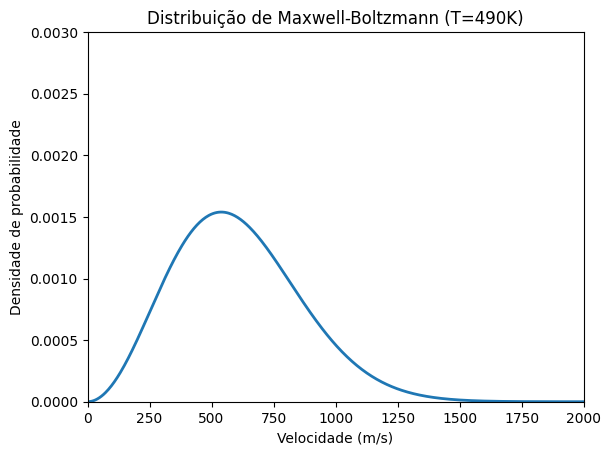

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Constantes
k = 1.38e-23  # Constante de Boltzmann em J/K
T_init = 100  # Temperatura inicial em Kelvin
T_final = 500  # Temperatura final em Kelvin
m = 4.65e-26  # Massa da molécula de gás (aproximadamente massa do N2) em kg

# Função de distribuição de Maxwell-Boltzmann
def maxwell_boltzmann_distribution(v, T, m):
    factor = (m / (2 * np.pi * k * T))**(3/2)
    return 4 * np.pi * (v**2) * factor * np.exp(-m * v**2 / (2 * k * T))

v = np.linspace(0, 2000, 500)  # Vetor de velocidades

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 0.003)
ax.set_xlabel('Velocidade (m/s)')
ax.set_ylabel('Densidade de probabilidade')
ax.set_title('Distribuição de Maxwell-Boltzmann')

def init():
    line.set_data([], [])
    return line,

def animate(T):
    prob_density = maxwell_boltzmann_distribution(v, T, m)
    line.set_data(v, prob_density)
    ax.set_title(f'Distribuição de Maxwell-Boltzmann (T={T}K)')
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=np.arange(T_init, T_final, 10), interval=100, blit=True)

# Salvar a animação como .gif
anim.save('maxwell_boltzmann_distribution.gif', writer=PillowWriter(fps=10))
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Constantes
k = 1.38e-23  # Constante de Boltzmann em J/K
T = 300  # Temperatura em Kelvin
m = 4.65e-26  # Massa da molécula de gás (aproximadamente massa do N2) em kg


In [ ]:
def maxwell_boltzmann_distribution(v, T, m):
    factor = (m / (2 * np.pi * k * T))**(3/2)
    return 4 * np.pi * (v**2) * factor * np.exp(-m * v**2 / (2 * k * T))


In [ ]:
v = np.linspace(0, 2000, 500)  # Vetor de velocidades
prob_density = maxwell_boltzmann_distribution(v, T, m)  # Densidade de probabilidade


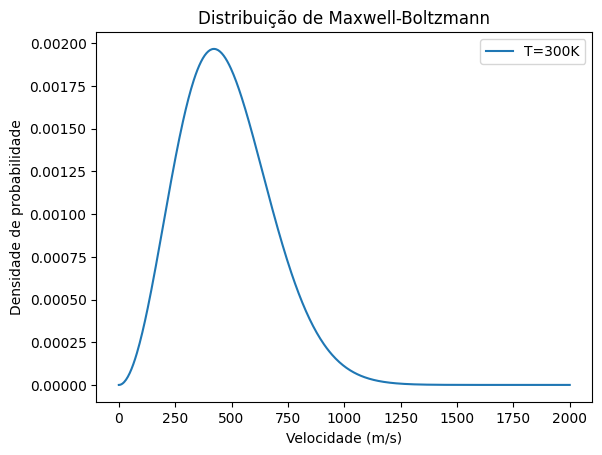

In [ ]:
fig, ax = plt.subplots()
ax.plot(v, prob_density, label=f'T={T}K')

ax.set_xlabel('Velocidade (m/s)')
ax.set_ylabel('Densidade de probabilidade')
ax.set_title('Distribuição de Maxwell-Boltzmann')
ax.legend()

plt.show()


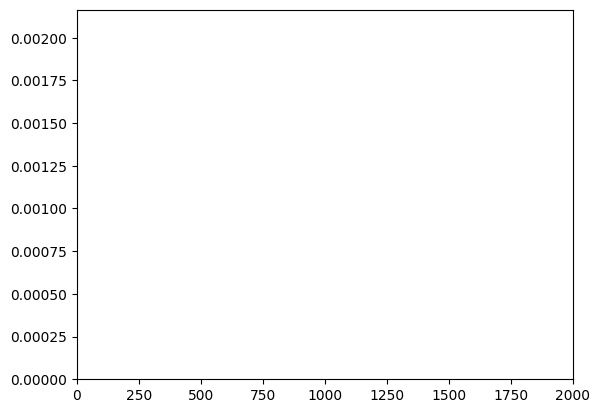

In [ ]:
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, 2000)
ax.set_ylim(0, np.max(prob_density) * 1.1)

def init():
    line.set_data([], [])
    return line,

def animate(T):
    prob_density = maxwell_boltzmann_distribution(v, T, m)
    line.set_data(v, prob_density)
    ax.set_title(f'Distribuição de Maxwell-Boltzmann (T={T}K)')
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=np.arange(100, 500, 10), interval=100, blit=True)
plt.show()


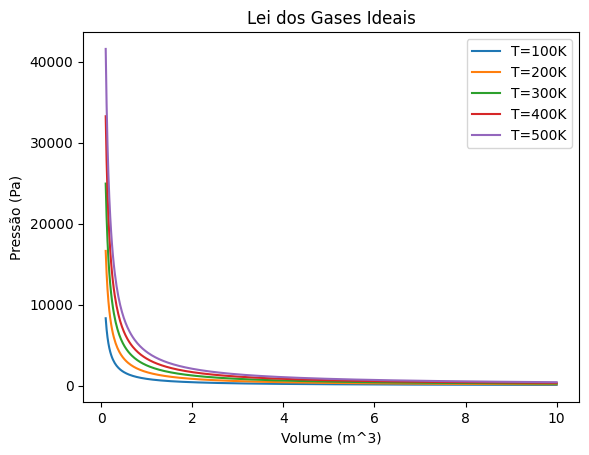

In [ ]:
R = 8.314  # Constante dos gases em J/(mol*K)
n = 1  # Número de mols

# Função para calcular a pressão
def ideal_gas_law(V, T, n, R):
    return (n * R * T) / V

V = np.linspace(0.1, 10, 500)  # Volume em m^3
T_values = [100, 200, 300, 400, 500]  # Diferentes temperaturas em K

fig, ax = plt.subplots()
for T in T_values:
    P = ideal_gas_law(V, T, n, R)
    ax.plot(V, P, label=f'T={T}K')

ax.set_xlabel('Volume (m^3)')
ax.set_ylabel('Pressão (Pa)')
ax.set_title('Lei dos Gases Ideais')
ax.legend()

plt.show()
